<a href="https://colab.research.google.com/github/khairulanwar24/apple-leaf-detection/blob/main/optimizer-rmsprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

from tensorflow.keras import models, layers
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Concatenate, Add, Reshape, AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, array_to_img, img_to_array

from tensorflow.keras.applications import EfficientNetB7

In [2]:
# Mengatur folder path dari Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
base_path = "/content/gdrive/MyDrive/apple-leaf-dataset"

In [4]:
#Checking the number of Images each Folder

for i in os.listdir(base_path):
    new_loc = os.path.join(base_path, i)
    new_jpg = os.path.join(new_loc, '*.jpg')
    new_JPG = os.path.join(new_loc, '*.JPG')

    images_jpg = glob(new_jpg)
    images_JPG = glob(new_JPG)

    total_images = len(images_jpg) + len(images_JPG)

    print(f'{i}: {total_images} images')

Apple scab: 2000 images
Apple Cedar  rust: 2000 images
Apple Black rot: 2000 images
Apple healthy: 2000 images


In [5]:
# Getting the classes
classes = os.listdir(base_path)
print(classes)

['Apple scab', 'Apple Cedar  rust', 'Apple Black rot', 'Apple healthy']


In [6]:
pip install split-folders

In [7]:
import splitfolders
splitfolders.ratio(base_path,seed = 1337 , output = 'split2' , ratio = (0.8,0.1,0.1))

Copying files: 8000 files [04:15, 31.28 files/s] 


In [8]:
# Path ke dataset di Google Drive
train_path = '/content/split2/train'
val_path = '/content/split2/val'
test_path = '/content/split2/test'

In [9]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS   = 3

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   zoom_range = 0.2,
                                   vertical_flip=True,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical',
                                              shuffle=True)

valid_set = valid_datagen.flow_from_directory(val_path,
                                            target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                             shuffle=True)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                           shuffle=True)

Found 6400 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [12]:
print(len(train_set))
print(len(valid_set))
print(len(test_set))

200
25
25


In [13]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [14]:
pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [15]:
import efficientnet.keras as efn

In [16]:
base_model = efn.EfficientNetB7(weights='imagenet',
                   include_top=False,
                   input_shape=input_shape)

''''base_model = keras.applications.EfficientNetB7(
    weights="imagenet",  # load weights pretrained on the ImageNet
    input_shape=(256, 256, 3),
    include_top=False  # do not include the ImageNet classifier at the top
)'''

258434480/258434480 [==============================] - 16s 0us/step


'\'base_model = keras.applications.EfficientNetB7(\n    weights="imagenet",  # load weights pretrained on the ImageNet\n    input_shape=(256, 256, 3),\n    include_top=False  # do not include the ImageNet classifier at the top\n)'

In [17]:
for layer in base_model.layers:
    layer.trainable=False

x = tf.keras.layers.Flatten()(base_model.output)
# x = tf.keras.layers.Dense(512,activation="relu")(x)
# x = tf.keras.layers.Dense(128,activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
prediction = tf.keras.layers.Dense(4, activation='softmax')(x)

efficient_net_model = Model(inputs=base_model.input, outputs=prediction)

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='loss'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.75
                                            , min_lr=0.00001)

In [20]:
efficient_net_model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=["accuracy"]
)


efficient_net_history = efficient_net_model.fit(train_set,
                                steps_per_epoch=len(train_set),
                                validation_data=valid_set,
                                epochs=30,
                                callbacks=[learning_rate_reduction],
                                validation_steps=len(valid_set),
                                verbose=1,
                            )

Epoch 1/30
200/200 [==============================] - 150s 623ms/step - loss: 3.9969 - accuracy: 0.7422 - val_loss: 0.8923 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 2/30
200/200 [==============================] - 118s 590ms/step - loss: 1.9576 - accuracy: 0.8608 - val_loss: 0.3004 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 3/30
200/200 [==============================] - 115s 574ms/step - loss: 1.5955 - accuracy: 0.8869 - val_loss: 0.5066 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 4/30
200/200 [==============================] - 118s 590ms/step - loss: 1.3848 - accuracy: 0.9059 - val_loss: 0.2713 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 5/30
200/200 [==============================] - 117s 583ms/step - loss: 1.3238 - accuracy: 0.9153 - val_loss: 1.1470 - val_accuracy: 0.9287 - lr: 0.0010
Epoch 6/30
200/200 [==============================] - 117s 585ms/step - loss: 1.1204 - accuracy: 0.9236 - val_loss: 0.6750 - val_accuracy: 0.9513 - lr: 0.0010
Epoch 7/30
200/200 [==========================

In [21]:
scores1 = efficient_net_model.evaluate(valid_set)
scores1

25/25 [==============================] - 9s 355ms/step - loss: 0.0582 - accuracy: 0.9912


[0.058213453739881516, 0.9912499785423279]

In [22]:
scores2 = efficient_net_model.evaluate(test_set)
scores2

25/25 [==============================] - 10s 377ms/step - loss: 0.0417 - accuracy: 0.9937


[0.0417000912129879, 0.9937499761581421]

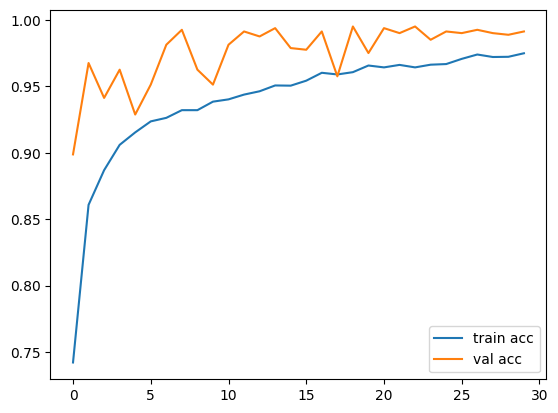

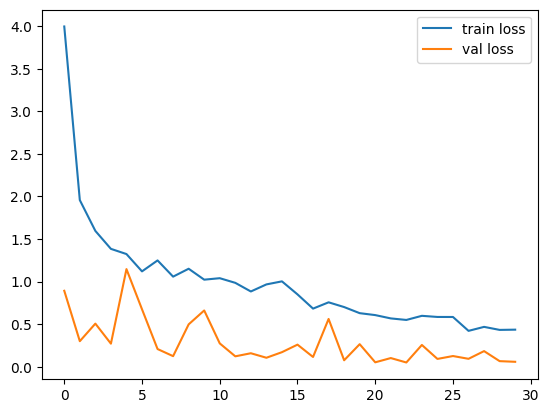

In [23]:
# Accuracy
plt.plot(efficient_net_history.history['accuracy'], label='train acc')
plt.plot(efficient_net_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# Loss
plt.plot(efficient_net_history.history['loss'], label='train loss')
plt.plot(efficient_net_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [24]:
class_names = list(train_set.class_indices.keys())
class_names

['Apple Black rot', 'Apple Cedar  rust', 'Apple healthy', 'Apple scab']

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 83ms/step


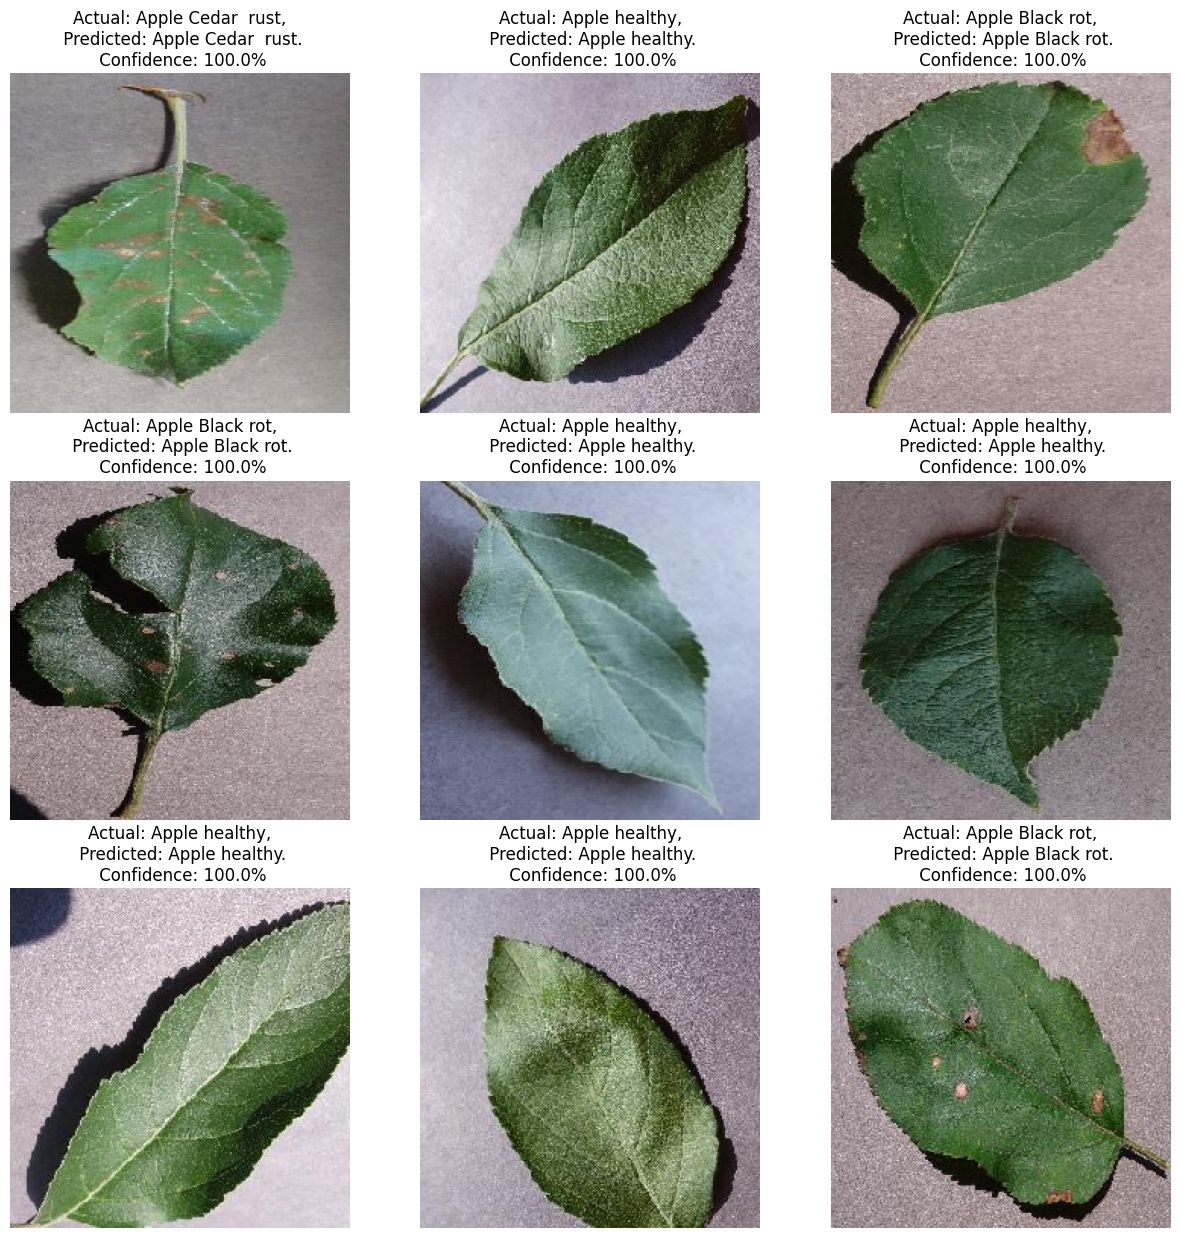

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_set:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(efficient_net_model, images[i])
        index = labels[i].argmax(axis=0)
        actual_class = class_names[index]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

In [27]:
valid_set1 = valid_datagen.flow_from_directory(val_path,
                                            target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                             shuffle=False)

Found 800 images belonging to 4 classes.


In [28]:
pip install seaborn


25/25 [==============================] - 13s 338ms/step


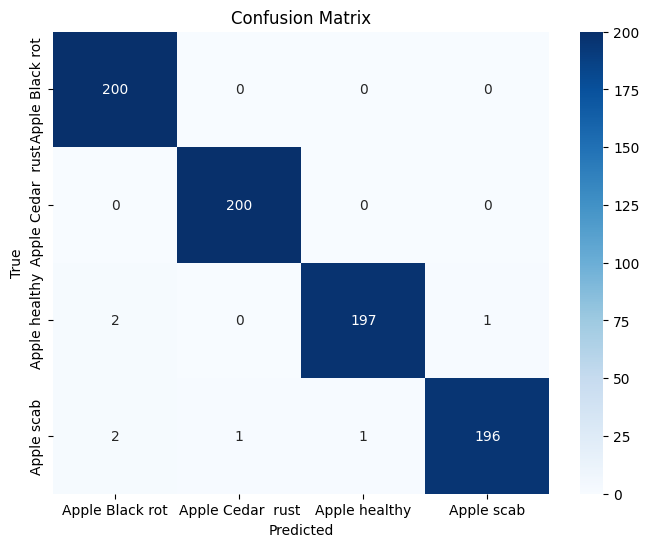

                   precision    recall  f1-score   support

  Apple Black rot       0.98      1.00      0.99       200
Apple Cedar  rust       1.00      1.00      1.00       200
    Apple healthy       0.99      0.98      0.99       200
       Apple scab       0.99      0.98      0.99       200

         accuracy                           0.99       800
        macro avg       0.99      0.99      0.99       800
     weighted avg       0.99      0.99      0.99       800



In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ...

Y_pred = efficient_net_model.predict(valid_set1, steps=len(valid_set1))
y_pred = np.argmax(Y_pred, axis=1)
y_true = valid_set1.classes
class_names = list(valid_set1.class_indices.keys())

# Menampilkan Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Menampilkan Confusion Matrix dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


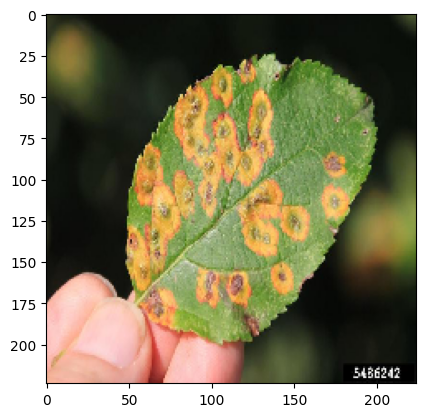

1/1 [==============================] - 0s 45ms/step
Predicted Class: Apple Black rot
Confidence: 100.0%


In [34]:
# Path ke gambar yang akan diprediksi
image_path_to_predict = "/content/gdrive/MyDrive/Data Testing/cedar-apple2.jpg"

# Tampilkan gambar
img_to_predict = load_img(image_path_to_predict, target_size=(IMAGE_SIZE, IMAGE_SIZE))
plt.imshow(img_to_predict)
plt.show()

# Prediksi gambar
predicted_class, confidence = predict(efficient_net_model, img_to_predict)

# Tampilkan hasil prediksi
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence}%")


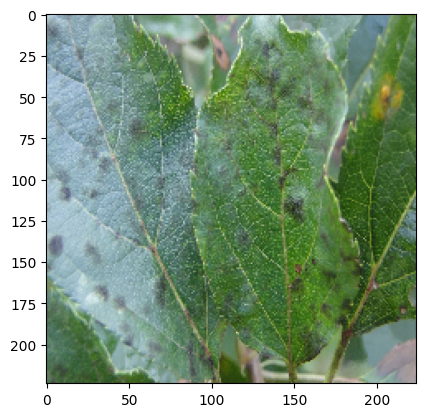

1/1 [==============================] - 0s 45ms/step
Predicted Class: Apple scab
Confidence: 100.0%


In [32]:
# Path ke gambar yang akan diprediksi
image_path_to_predict = "/content/gdrive/MyDrive/Data Testing/scab-apple.jpg"

# Tampilkan gambar
img_to_predict = load_img(image_path_to_predict, target_size=(IMAGE_SIZE, IMAGE_SIZE))
plt.imshow(img_to_predict)
plt.show()

# Prediksi gambar
predicted_class, confidence = predict(efficient_net_model, img_to_predict)

# Tampilkan hasil prediksi
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence}%")


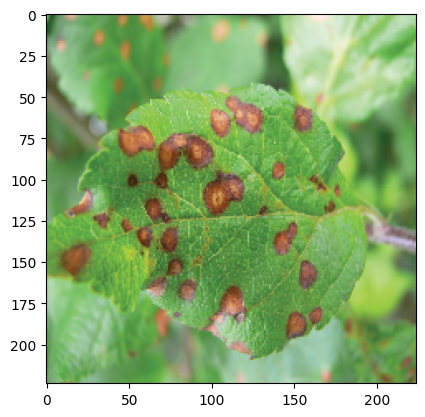

1/1 [==============================] - 0s 44ms/step
Predicted Class: Apple Black rot
Confidence: 100.0%


In [33]:
# Path ke gambar yang akan diprediksi
image_path_to_predict = "/content/gdrive/MyDrive/Data Testing/black rot.jpeg"

# Tampilkan gambar
img_to_predict = load_img(image_path_to_predict, target_size=(IMAGE_SIZE, IMAGE_SIZE))
plt.imshow(img_to_predict)
plt.show()

# Prediksi gambar
predicted_class, confidence = predict(efficient_net_model, img_to_predict)

# Tampilkan hasil prediksi
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence}%")


In [ ]:
# Simpan model ke file .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(efficient_net_model)
tflite_model = converter.convert()
tflite_path = "/content/gdrive/MyDrive/tflite-anwar/modelrmsprop30epoch.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print("Model berhasil disimpan sebagai model.tflite di Google Drive.")